In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
from fastai.callbacks import *

In [ ]:
experiment_name = 'nn-distribution'

In [3]:
path = Path('../../data/results/experiment4')

In [4]:
df = pd.read_csv(path/'best_known.csv')
best_known_fitness = df['fitness'].values
best_known_sumcv = df['sum_constraints'].values

In [5]:
D = 30
runs = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times =100 
total_generations = max_times * frequency + 1000

In [6]:
class VAELoss(nn.Module):
    def __init__(self, hooks):
        super().__init__()
        self.hooks,self.loss_func = hooks,nn.MSELoss()
        
    def forward(self, input, target):
        base_loss = self.loss_func(input,target)
        mu,logvar = self.hooks.stored
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return base_loss + kl_loss
    
class VAEModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.mu     = nn.Linear(nf*w,d)
        self.logvar = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def sample(self, fts):
        mu = self.mu(fts)
        std = torch.exp(0.5 * self.logvar(fts))
        sample = mu + torch.randn_like(std)*std
        return sample

    def forward(self, x):
        fts = self.act(torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1))
        return self.sample(fts)

In [7]:
nn_pick = 3 # how many individuals we predict
nn_window = 5 # time window used to predict next optimal

In [8]:
experiment=4


if experiment==1:
    ab = pd.read_csv(path/'dC_01.csv')['b'].values
    def fitness_func(indiv, b, t): return (indiv.data**2).sum()
    def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
    
elif experiment==2:
    ab = pd.read_csv(path/'dC_01.csv')['b'].values
    def fitness_func(indiv, b, t): return (indiv.data**2).sum()
    def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
elif experiment==3:
    ab=[]
    # experiment 3: dynamic fitness function (linear)
    def fitness_func(indiv, b, t): return ((indiv.data + 0.1*t)**2).sum()
    def constraint_func(indiv, b, t): return 0
    
else:
    ab=[]
# experiment 4: dynamic fitness function (x-sin(pi/2*t))^2
    def fitness_func(indiv, b, t): return ((indiv.data-np.sin(np.pi/2*t))**2).sum()
    def constraint_func(indiv, b, t): return 0

Total time: 00:59
SpeedMetric(success rate): 0.0000
ModifiedOfflineError: 0.6540
OfflineError: 0.6540
AbsoluteRecoverRate: 1.0767


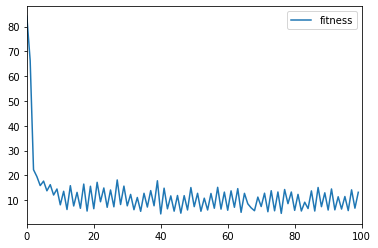

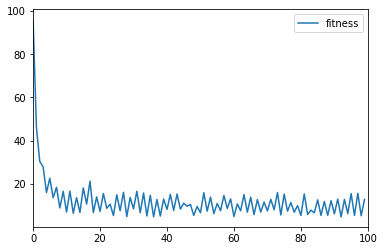

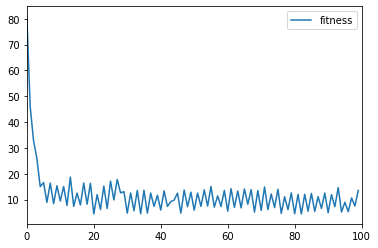

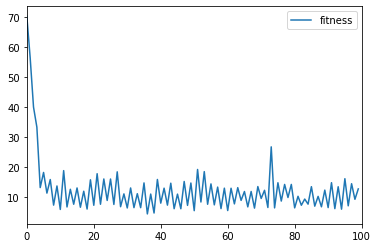

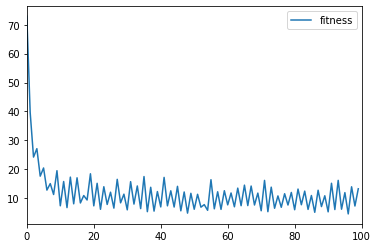

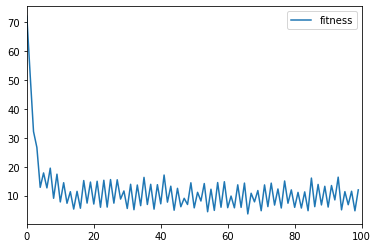

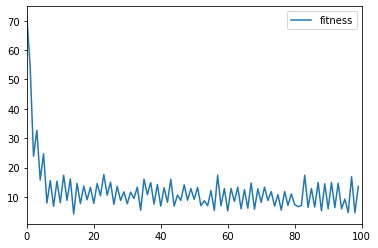

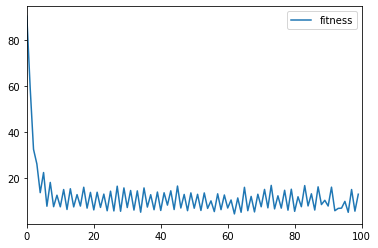

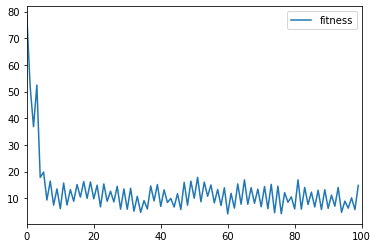

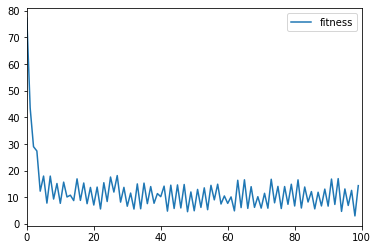

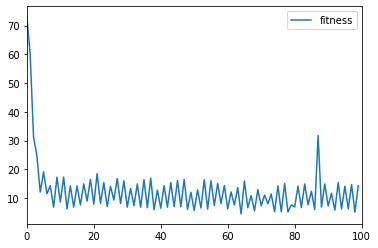

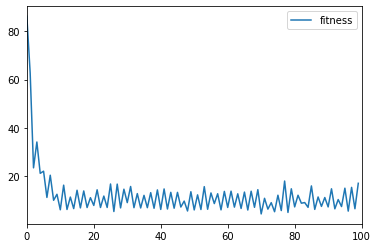

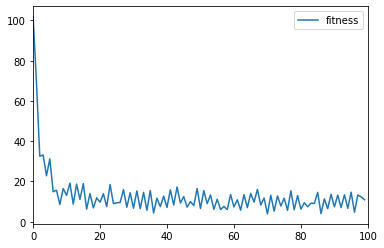

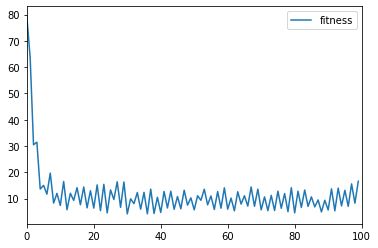

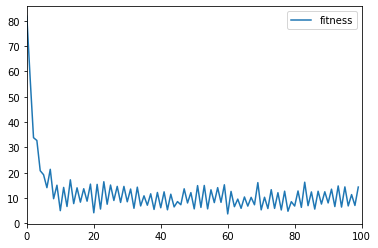

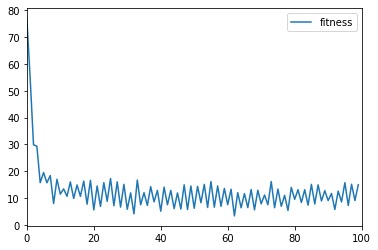

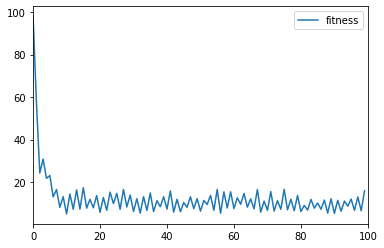

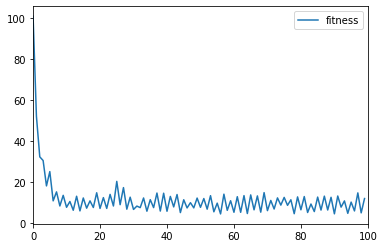

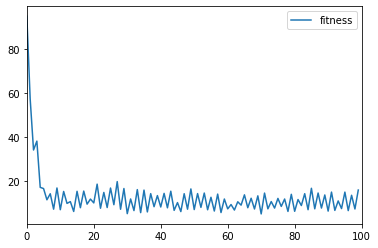

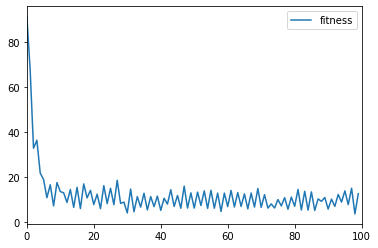

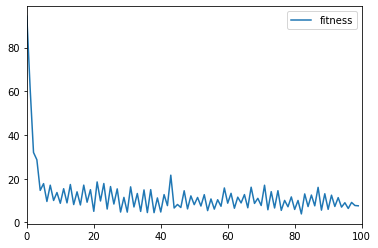

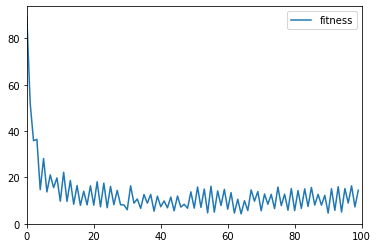

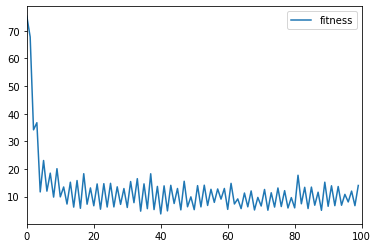

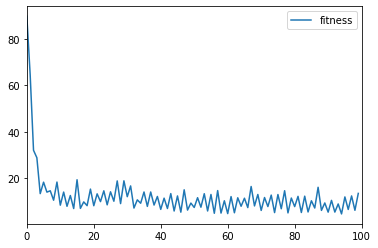

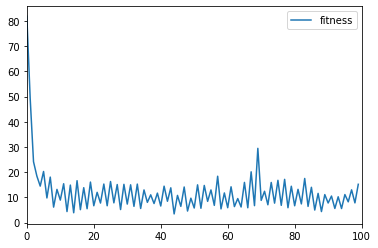

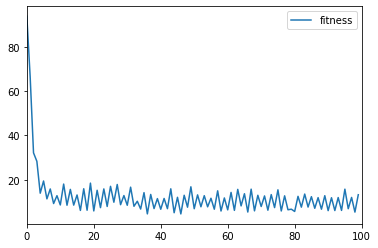

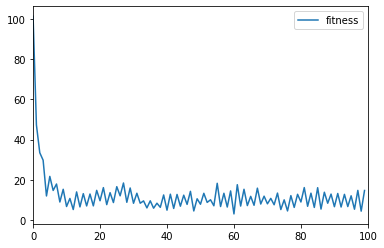

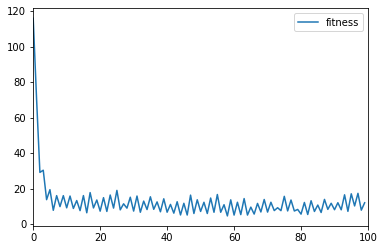

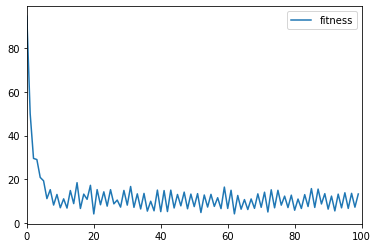

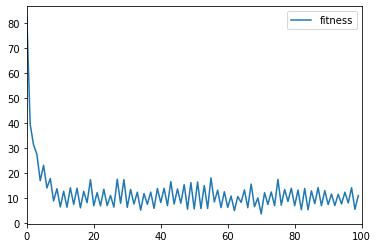

In [9]:
results = {'mof':[], 'sr':[], 'nfe':[], 'fitness':[], 'sumcv':[], 'arr':[]}

for run in range(runs):
    model = VAEModel()
    hooks = hook_outputs([model.mu,model.logvar], detach=False)
    loss_func = VAELoss(hooks)
    population = Population.new_random(dimension=D)
    nn_trainer = partial(NNTrainerNoNoise, model=model, loss_func=loss_func, window=nn_window)

    speed_metric = partial(SpeedMetric, threadhold=0.2)

    opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                       max_times=max_times, frequency=frequency, callbacks=[nn_trainer],
                       metrics=[speed_metric, ModifiedOfflineError, OfflineError, AbsoluteRecoverRate],
                       optimal_fitness_values=best_known_fitness, optimal_sum_constraints=best_known_sumcv)
    opt.state_dict
    opt.run(total_generations)
    # saving results
    results['mof'].append(opt.modified_offline_error.metrics)
    results['arr'].append(opt.absolute_recover_rate.metrics)
    results['sr'].append(opt.speed_metric.metrics)
    results['nfe'].append(opt.speed_metric.speeds)
    results['fitness'].append(opt.recorder.best_times_fitness)
    results['sumcv'].append(opt.recorder.best_times_constraints) 

In [10]:
df = pd.DataFrame({'fitness':opt.recorder.best_times_fitness, 'sum_constraints':opt.recorder.best_times_constraints})
df.head()

,fitness,sum_constraints
0,82.647593,0
1,39.508590,0
2,31.321252,0
3,27.546706,0
4,16.968916,0


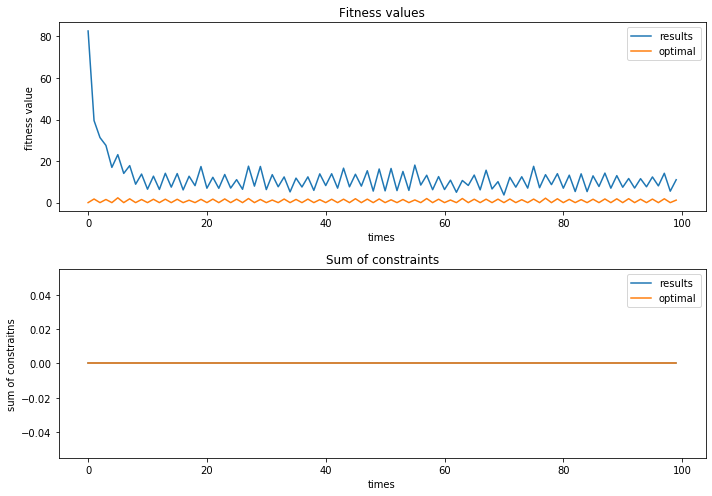

In [11]:
opt.recorder.plot();

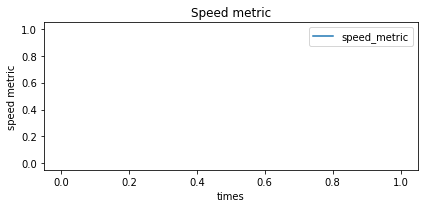

In [12]:
opt.recorder.plot_metrics();

In [13]:
pd.DataFrame({'mof':results['mof']}).to_csv(path/f'{experiment_name}_mof.csv', index=False)
pd.DataFrame({'sr':results['sr']}).to_csv(path/f'{experiment_name}_sr.csv', index=False)
pd.DataFrame(results['nfe']).to_csv(path/f'{experiment_name}_nfe.csv', index=False)
pd.DataFrame(results['fitness']).to_csv(path/f'{experiment_name}_fitness.csv', index=False)
pd.DataFrame(results['sumcv']).to_csv(path/f'{experiment_name}_sumcv.csv', index=False)
pd.DataFrame(results['arr']).to_csv(path/f'{experiment_name}_arr.csv', index=False)